# Practical 6: Attention and Transformers

A typical Seq2seq model is limited by fixed size input and output vectors. For many tasks, such as Machine Translation (MT), text summarisation and generating text with a language model, we may wish to output different size sequences. The performance of Seq2seq models may also be limited by the single fixed-size context vector produced by the encoder, which reduces the amount of information passed to the decoder. The attention mechanism aims to solve these issues. Instead of encoding a single context vector the encoder produces a *sequence* of vectors, one for each timestep of the input. The attention mechanism then allows the decoder to 'pay attention' to the important important inputs and ignore less important ones.

Although attention mechanisms often result in a significant performance boost on many task, the recurrent nature of Seq2seq architecture means it is slow to train. To overcome this issue Vaswani, A. et al. (2017) proposed a new architecture, the Transformer, which throws away recurrence and focuses only on attention. [Attention is all you need!](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). Transformers have since become the basis for nearly all state-of-the-art models for language modelling, classification, MT, summarisation and many other NLP tasks.

In the first part of this practical we will create a Seq2seq model with attention for MT. The MT model will be trained to translate English sentences into French with an [English to French](http://www.manythings.org/anki/) dataset. Once trained, we will be able to translate English phrases and visualise the weights of the attention mechanism to understand which English words were 'attended to' in order to produce the translation.

In the second part of this practical we will create a Transformer-based translator by fine-tuning an existing model, the [T5](https://arxiv.org/abs/1910.10683v3), on our translation dataset.

The objectives of this practical are:
1. Understand how Seq2seq architecture and attention mechanisms work, and help the model to identify the important features of input sequences

2. Introduce a new ML library, Hugging Face 🤗 Transformers that is usefull for building and fine-tuning large Transformer models

3. Compare and contrast recurrent Seq2seq with attention to a transfer learning approach using a large pre-trained language model (T5), based on Transformer architecture, for MT

# 1 Translation with Seq2Seq and Attention

## 1.0 Import libraries

In [1]:
import os
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import tensorflow as tf
from collections import Counter
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate import meteor, meteor_score
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
%matplotlib inline

# Set the directory to the data folder
data_dir = os.path.join('..', 'datasets', 'translate')

ModuleNotFoundError: No module named 'nltk'

## 1.1 Load and pre-process data

The data directory should contain the English and French text file. We will simply loop over the file and separate the English and French phrases. Then perform some simple normalisation by removing accents from the french words and keeping only basic punctuation symbols (.,!? and '), and then tokenise and remove extra whitespace.

<div class = "alert alert-block alert-info"><b>Note:</b> This dataset contains ~200K sentence pairs, which would take a very long time to train and evaluate. So, we will limit our data to the first 100k sentences.</div>

In [ ]:
def preprocess_sentence(sentence):
    # Remove accents
    sentence = unicodedata.normalize('NFD', sentence).encode('ascii', 'ignore')
    # Convert back to unicode
    sentence = sentence.decode('UTF-8')

    # Replace everything with space except (a-z, A-Z, ".", "?", "!", "'", ",")
    sentence = re.sub(r"[^a-zA-Z?.!',¿]+", " ", sentence)

    # Create a space between word and the punctuation following it
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)

    # Lowercase and remove leading/trailing spaces
    sentence = sentence.lower().strip()

    # Tokenize
    tokens = sentence.split()

    return tokens

# Preprocess the English and French sentences
eng_corpus = []
fr_corpus = []
with open(os.path.join(data_dir, 'eng-fr.txt'), 'r', encoding='utf-8') as file:
    text = file.read().splitlines()

    for line in text[:100000]:
        # Split the line into English and French
        line = line.split('\t')

        # Add to corpus
        eng_corpus.append(preprocess_sentence(line[0]))
        fr_corpus.append(preprocess_sentence(line[1]))

print('Number of English sentences: ' + str(len(eng_corpus)))
print('Number of French sentences: ' + str(len(fr_corpus)))
print('First 5 sentences: ')
for i in range(5):
    print(' '.join(eng_corpus[i]) + ' -> ' + ' '.join(fr_corpus[i]))

We can plot the distribution of sentence lengths to determin how long the input sequences should be.

In [ ]:
# Plot the distribution of sentence lengths
eng_seq_lengths = [len(sent) for sent in eng_corpus]
fr_seq_lengths = [len(sent) for sent in fr_corpus]
print("Longest English sentence: " + str(max(eng_seq_lengths)))
print("Longest French sentence: " + str(max(fr_seq_lengths)))

df = pd.DataFrame({'English': eng_seq_lengths, 'French': fr_seq_lengths})
df = df.melt(var_name='Language', value_name='Sentence Length')
sns.displot(df, x='Sentence Length', hue='Language', kind='hist', palette='tab10', height=5, aspect=2)
plt.show()

### Build a vocabulary

Create a vocabulary for both English and French. As with language modelling, increasing the vocabulary size greatly increases the complexity of the task, because each output prediction is a word from the vocabulary. However, if either vocabulary is too small the model will not be able to learn a complete mapping between the words, so we will keep all words in the vocabulary.

In [5]:
def create_vocabulary(corpus, vocab_size=None, min_freq=1, special_tokens=None):

    # Count the frequency of each token in the corpus
    word_counter = Counter()
    for sent in corpus:
        word_counter.update(sent)

    if min_freq > 1:
        # Remove tokens that occur less than min_freq times
        word_counter =  Counter({word: count for word, count in word_counter.items() if count >= min_freq})

    # Create a vocabulary
    vocab = []
    vocab_size = len(word_counter) if vocab_size is None else vocab_size

    # Add the special tokens to the vocabulary
    if special_tokens and isinstance(special_tokens, list):
        vocab.extend(special_tokens)
    else:
        special_tokens = []

    # Add the vocab_size most common tokens to the vocabulary
    vocab.extend([word for word, count in word_counter.most_common(vocab_size - len(special_tokens))])

    return vocab

# Create a vocabulary
eng_vocab = create_vocabulary(eng_corpus, vocab_size=None, min_freq=1, special_tokens=['<pad>', '<unk>', '<s>', '</s>'])
fr_vocab = create_vocabulary(fr_corpus, vocab_size=None, min_freq=1, special_tokens=['<pad>', '<unk>', '<s>', '</s>'])

# Print the vocabulary
print("English vocabulary size: " + str(len(eng_vocab)))
for i, word in enumerate(eng_vocab[:50]):
    print(f'({str(i)}, {word})', end=' ')
print()
print("French vocabulary size: " + str(len(fr_vocab)))
for i, word in enumerate(fr_vocab[:50]):
    print(f'({str(i)}, {word})', end=' ')

English vocabulary size: 9143
(0, <pad>) (1, <unk>) (2, <s>) (3, </s>) (4, .) (5, i) (6, you) (7, ?) (8, a) (9, to) (10, the) (11, tom) (12, is) (13, it) (14, do) (15, that) (16, this) (17, me) (18, i'm) (19, he) (20, are) (21, don't) (22, have) (23, was) (24, we) (25, my) (26, your) (27, of) (28, not) (29, what) (30, you're) (31, be) (32, in) (33, did) (34, like) (35, can) (36, all) (37, they) (38, want) (39, for) (40, it's) (41, she) (42, know) (43, go) (44, on) (45, ,) (46, very) (47, how) (48, here) (49, no) 
French vocabulary size: 16789
(0, <pad>) (1, <unk>) (2, <s>) (3, </s>) (4, .) (5, je) (6, ?) (7, vous) (8, a) (9, pas) (10, de) (11, tom) (12, ne) (13, est) (14, tu) (15, le) (16, il) (17, que) (18, la) (19, nous) (20, ce) (21, un) (22, !) (23, suis) (24, j'ai) (25, c'est) (26, une) (27, en) (28, me) (29, les) (30, ca) (31, ,) (32, moi) (33, elle) (34, etes) (35, faire) (36, tout) (37, te) (38, fait) (39, sont) (40, qui) (41, pour) (42, mon) (43, n'est) (44, ils) (45, veux) (4

## 1.2 Create a data generator

As with language modelling, the number of inputs required for training is larger than the number of phrase pairs in the data, so we will use a Generator class to feed data into the model. For each input/output pair we need to generate:

1. Encoder inputs, the English phrase

2. Decoder inputs, the French phrase including the `<s>` token, but not including the `</s>` token (so the decoder has the context vector(s) and a token to start generating from)

3. Decoder outputs, the French phrase including the `</s>` token, but not including the `<s>` token (so the decoder learns to generate output untill the `</s>` token is reached)

<div class = "alert alert-block alert-info"><b>Note:</b> We could perform all pre-processing within the data generator, such as tokenisation and lowercasing. However, for simplicity and to allow the creation of a vocabulary, here we only preform the step which greatly increase memory requirements.</div>

In [6]:
class MTDataGenerator(tf.keras.utils.Sequence):
    """Custom data generator for machine translation."""

    def __init__(self, in_data, out_data, in_vocab, out_vocab, max_seq_len, batch_size, shuffle=True):
        
        self.in_data = in_data
        self.out_data = out_data
        self.in_vocab = in_vocab
        self.out_vocab = out_vocab

        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Get the data indexes and shuffle
        self.indexes = np.arange(len(self.in_data))
        self.on_epoch_end()
    
    def on_epoch_end(self):
        """Updates data after each epoch. Currently only shuffles data if shuffle=True."""
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        """Calculates the number of batches per epoch (num_sent / batch_size)."""
        return int(np.ceil(len(self.in_data) / self.batch_size))

    def __getitem__(self, index):
        """Generates a batch of data."""

        # Generate batch of inputs and outputs
        batch_enc_inputs, batch_dec_inputs, batch_outputs = [], [], []

        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        for ind in batch_indexes:

            # Get the sentence
            in_sent = self.in_data[ind]
            out_sent = self.out_data[ind]
            
            # Vectorise the sentences
            in_sent_vector = [self.in_vocab.index(word) if word in self.in_vocab else self.in_vocab.index('<unk>') for word in in_sent]
            out_sent_vector = [self.out_vocab.index(word) if word in self.out_vocab else self.out_vocab.index('<unk>') for word in out_sent]

            # Add the start and end tokens
            in_sent_vector = [self.in_vocab.index('<s>')] + in_sent_vector + [self.in_vocab.index('</s>')]
            out_sent_vector = [self.out_vocab.index('<s>')] + out_sent_vector + [self.out_vocab.index('</s>')]

            # Add the sentences to the batch
            batch_enc_inputs.append(in_sent_vector)
            batch_dec_inputs.append(out_sent_vector[:-1])
            batch_outputs.append(out_sent_vector[1:])

        # Pad the sentences to the max_seq_len
        batch_enc_inputs = pad_sequences(batch_enc_inputs, maxlen=self.max_seq_len, padding='post', truncating='post', value=0.0)
        batch_dec_inputs = pad_sequences(batch_dec_inputs, maxlen=self.max_seq_len, padding='post', truncating='post', value=0.0)
        batch_outputs = pad_sequences(batch_outputs, maxlen=self.max_seq_len, padding='post', truncating='post', value=0.0)

        # Conver input/outputs to numpy arrays
        batch_enc_inputs = np.array(batch_enc_inputs)
        batch_dec_inputs = np.array(batch_dec_inputs)
        batch_outputs = np.array(batch_outputs)

        return (batch_enc_inputs, batch_dec_inputs), batch_outputs

# Set the maximum sequence length and batch size
max_seq_len = 20
batch_size = 128

# Create a train and validation set data generator
eng_train, eng_val, fr_train, fr_val = train_test_split(eng_corpus, fr_corpus, test_size=0.2, random_state=42)
train_generator = MTDataGenerator(eng_train, fr_train, eng_vocab, fr_vocab, max_seq_len=max_seq_len, batch_size=batch_size)
val_generator = MTDataGenerator(eng_val, fr_val, eng_vocab, fr_vocab, max_seq_len=max_seq_len, batch_size=batch_size)

# Print the number of batches
print('Number of training batches: ' + str(len(train_generator)))
print('Number of validation batches: ' + str(len(val_generator)))

# Print the first examples
inputs, outputs = train_generator[0]
enc_inputs, dec_inputs = inputs

print(enc_inputs.shape)
print(dec_inputs.shape)
print(outputs.shape)
for i in range(3):
    print('Input Sentence: ' + ' '.join([eng_vocab[word] for word in enc_inputs[i]]))
    print('Input Vector: ' + str(enc_inputs[i]))
    print('Target Sentence: ' + ' '.join([fr_vocab[word] for word in outputs[i]]))
    print('Target Vector: ' + str(outputs[i]))
    print()

Number of training batches: 625
Number of validation batches: 157
(128, 20)
(128, 20)
(128, 20)
Input Sentence: <s> i really missed you . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Input Vector: [  2   5  80 507   6   4   3   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Target Sentence: tu m'as vraiment manque . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Target Vector: [ 14 545  81 384   4   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]

Input Sentence: <s> hug me tight . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Input Vector: [   2 1002   17  923    4    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
Target Sentence: serrez moi bien fort . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Target Vector: [2771   32   74  182    4    3    0    0    0    0    0    0    0 

## 1.3 Build the Seq2Seq with Attention Model

The following cells define a Seq2Seq model which uses GRU recurrent layers and an attention mechanism. Both the attention mechanism and Seq2Seq make use of subclassing, which allows us to define our own layers and model classes that inherit the behaviour of the built-in Keras layers and models.

The `BahdanauAttention` class below implements (additive) Bahdanau style attention as a Keras layer. Attention is calculated for all inputs in a batch within the `call()` method:

1. The score is calculated with $V.tahn(W_1.h + W_2.s)$

2. The attention weights ($a$) are calculated by softmaxing the score

3. The context vector is then $\sum_{i=1}^{n}a.h$

Take some time to understand what the `BahdanauAttention` class below is doing. Particularly the `call()` method.

In [7]:
# Attention Mechanism
class BahdanauAttention(tf.keras.layers.Layer):

  def __init__(self, units):
    super(BahdanauAttention, self).__init__(name='BahdanauAttention')
    
    # Define the layers
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # Query is the decoder hidden state shape=(batch_size, hidden_size)
    # Values is the encoder output shape=(batch_size, max_seq_len, hidden_size)

    # Expand for time dimension shape=(batch_size, 1, hidden_size)
    query_with_time_axis = tf.expand_dims(query, 1)

    # Calculate score shape=(batch_size, max_length, 1)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    # Attention weights shape=(batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # Context vector shape=(batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

The `Translator` class below implements Seq2Seq with attention as a Keras model. The algorithm is implemented within the `call()` method:

1. First the inputs are encoded with the encoder layers

2. Then, for each timestep ($t$) decode the sequence:
    
    1. Calculate the context vector by applying attention to the current decoder state and encoder outputs

    2. Concatentate the context vector and decoder inputs, and pass to the decoder

    3. Generate the predicted token from the decoder outputs

<div class = "alert alert-block alert-info"><b>Note:</b> During training the model uses teacher forcing, which, regardless of the predicted token, adds the actual (ground truth) token to the decoder inputs at each timestep. This is, of course, not valid during evaluation/inference, where the predicted token is appended to the decoder input for the next timestep.</div>

The remaining functions are utility functions for generating translations with a trained model:

1. `single_predict()` applies the same training loop defined in `call()`, but also returns the attention weights (this would not work with the `fit()` method)

2. `translate()` takes a sentence (string) as input, applies the necessary pre-processing, and generates a predicted output sentence as well as an attention plot from the attention weights

3. `plot_attention()` generates a heatmap from the attention weights, which shows their magnitude with respect to each input/output token in the processed sequence

Take some time to understand what the `Translator` class below is doing. Particularly the `call()` and `translate()` methods.

In [9]:
class Translator(tf.keras.Model):

    def __init__(self, eng_vocab, fr_vocab, max_seq_len, embedding_dim, recurrent_units, attn_units):
        super().__init__(name='Translator')

        self.eng_vocab = eng_vocab
        self.fr_vocab = fr_vocab
        self.max_seq_len = max_seq_len
        self.embedding_dim = embedding_dim
        self.recurrent_units = recurrent_units
        self.attn_units = attn_units

        # Define the encoder and decoder layers
        self.enc_embedding = tf.keras.layers.Embedding(
            len(self.eng_vocab),
            self.embedding_dim,
            mask_zero=True,
            name='encoder_embedding')
        self.encoder = layers.GRU(self.recurrent_units, return_sequences=True, return_state=True, name='encoder')

        self.dec_embedding = tf.keras.layers.Embedding(
            len(self.fr_vocab),
            self.embedding_dim,
            mask_zero=True,
            name='decoder_embedding')
        self.attention_layer = BahdanauAttention(self.attn_units)
        self.decoder= layers.GRU(self.recurrent_units, return_sequences=True, return_state=True, name='decoder')
        self.decoder_dense = layers.Dense(len(self.fr_vocab), activation='softmax', name='decoder_dense')


    def call(self, inputs, training=False):
        # Accumulate the decoder outputs/predictions
        all_outputs = []

        # Unpack the inputs
        encoder_inputs, decoder_inputs = inputs

        # Encode the inputs
        encoder_outputs = self.enc_embedding(encoder_inputs)
        encoder_outputs, encoder_state = self.encoder(encoder_outputs)

        # Set the initial decoder state to the encoder state
        decoder_state = encoder_state

        # Iterate over the decoder inputs one token at a time
        for t in range(self.max_seq_len):
            # Get the current decoder input
            # If training use the next decoder input (teacher forcing)
            if training:
                decoder_input = decoder_inputs[:, t]
            # Else use the predicted decoder input (i.e when using the model for inference)
            elif not training and t > 0:
                # Squash the output time dimension, shape=(batch_size, vocab_size)
                decoder_input = tf.squeeze(tf.argmax(decoder_outputs, axis=-1), axis=1) 
            # Else set the initial decoder input to the <s> token
            elif not training and t == 0:
                    current_batch_size = tf.shape(decoder_inputs)[0]
                    decoder_input = tf.fill([current_batch_size], self.fr_vocab.index('<s>'))

            # Embed the decoder input, shape=(batch_size, 1, embedding_dim)
            decoder_input = self.dec_embedding(decoder_input)
            decoder_input = tf.expand_dims(decoder_input, axis=1)

            # Calculate the context vector and attention weights, shape=(batch_size, 1, attn_units)
            context_vector, attention_weights = self.attention_layer(decoder_state, encoder_outputs)
            context_vector = tf.expand_dims(context_vector, axis=1)

            # Concatenate the context vector and decoder input, shape=(batch_size, 1, embedding_dim + attn_units)
            decoder_input = tf.concat([context_vector, decoder_input], axis=-1)

            # Pass the concatenated vector to the decoder GRU
            decoder_outputs, decoder_state = self.decoder(decoder_input, initial_state=decoder_state)

            # Generate the predictions and append to all_outputs shape=(batch_size, 1, vocab_size)
            decoder_outputs = self.decoder_dense(decoder_outputs)
            all_outputs.append(decoder_outputs)

        # Concatenate the outputs, shape=(batch_size, max_seq_len, vocab_size)
        outputs = tf.concat(all_outputs, axis=1)
        return outputs

    def single_predict(self, encoder_inputs):

        # Accumulate the decoder outputs/predictions and attention weights
        all_outputs = []
        attention_weights = []

        # Encode the inputs
        encoder_outputs = self.enc_embedding(encoder_inputs)
        encoder_outputs, encoder_state = self.encoder(encoder_outputs)

        # Set the initial decoder state to the encoder state
        decoder_state = encoder_state

        # Set the initial decoder input to the <s> token
        current_batch_size = tf.shape(encoder_inputs)[0]
        decoder_input = tf.fill([current_batch_size], self.fr_vocab.index('<s>'))

        # Iterate over the decoder inputs one token at a time
        for t in range(self.max_seq_len):

            # Embed the decoder input, shape=(batch_size, 1, embedding_dim)
            decoder_input = self.dec_embedding(decoder_input)
            decoder_input = tf.expand_dims(decoder_input, axis=1)

            # Calculate the context vector and attention weights, shape=(batch_size, 1, attn_units)
            context_vector, curr_attn_weights = self.attention_layer(decoder_state, encoder_outputs)
            context_vector = tf.expand_dims(context_vector, axis=1)

            # Store the attention weights to plot later on
            curr_attn_weights = tf.reshape(curr_attn_weights, (-1, ))
            attention_weights.append(curr_attn_weights)

            # Concatenate the context vector and decoder input, shape=(batch_size, 1, embedding_dim + attn_units)
            decoder_input = tf.concat([context_vector, decoder_input], axis=-1)

            # Pass the concatenated vector to the decoder GRU
            decoder_outputs, decoder_state = self.decoder(decoder_input, initial_state=decoder_state)

            # Generate the predictions and append to all_outputs shape=(batch_size, 1, vocab_size)
            decoder_outputs = self.decoder_dense(decoder_outputs)
            all_outputs.append(decoder_outputs)

            # Squash the output time dimension, shape=(batch_size, vocab_size)
            decoder_input = tf.squeeze(tf.argmax(decoder_outputs, axis=-1), axis=1) 

        # Concatenate the outputs, shape=(batch_size, max_seq_len, vocab_size)
        outputs = tf.concat(all_outputs, axis=1)
        # Stack the attention weights, shape=(batch_size, max_seq_len, max_seq_len)
        attention_weights = tf.stack(attention_weights)
        return outputs, attention_weights

    # Function to translate a sentence
    def translate(self, sentence):

        # Preprocess the sentence
        tokenised_sentence = ['<s>']  + preprocess_sentence(sentence) + ['</s>']
        
        # Vectorise and pad the sentence to the max sequence length
        encoder_input = [self.eng_vocab.index(word) for word in tokenised_sentence]
        encoder_input = tf.keras.preprocessing.sequence.pad_sequences([encoder_input], maxlen=self.max_seq_len, padding='post')

        # Generate the predictions and attention weights
        predictions, attention_weights = self.single_predict(encoder_input)

        # Get the predicted sentence
        predicted_ids = tf.argmax(predictions[0], axis=-1).numpy()
        predicted_sentence = [self.fr_vocab[i] for i in predicted_ids if self.fr_vocab[i] != '<pad>']

        # print('Input: {}'.format(sentence))
        # print('Predicted translation: {}'.format(' '.join(predicted_sentence[:-1])))

        # Only take the attention weights for the words in the sentence
        attention_weights = attention_weights[:len(predicted_sentence), :len(tokenised_sentence)]
        # Plot the attention weights
        attn_fig = self.plot_attention(attention_weights, tokenised_sentence, predicted_sentence)

        return ' '.join(predicted_sentence[:-1]), attn_fig

    # Function for plotting the attention weights
    def plot_attention(self, attention, sentence, predicted_sentence):

        # Plot the attention weights
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)
        ax.matshow(attention, cmap='viridis')

        # Set the x and y ticks (need to discard the first and last for some reason)
        yticks_loc = ax.get_yticks().tolist()[1:-1]
        ax.yaxis.set_major_locator(ticker.FixedLocator(yticks_loc))
        xticks_loc = ax.get_xticks().tolist()[1:-1]
        ax.xaxis.set_major_locator(ticker.FixedLocator(xticks_loc))
        # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        # Set the labels
        fontdict = {'fontsize': 14}
        ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

        # plt.show()
        return fig

# Hyperparameters
embedding_dim = 100
recurrent_units = 256
attn_units = 20

# Create the model
encoder_inputs = layers.Input(shape=(max_seq_len, ), name='encoder_inputs')
decoder_inputs = layers.Input(shape=(max_seq_len, ), name='decoder_inputs')
translator = Translator(eng_vocab, fr_vocab, max_seq_len, embedding_dim, recurrent_units, attn_units)
outputs = translator((encoder_inputs, decoder_inputs))

model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs, name='seq2seq_attn')
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "seq2seq_attn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 20)]         0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 20)]         0                                            
__________________________________________________________________________________________________
Translator (Translator)         (None, 20, 16789)    7664770     encoder_inputs[0][0]             
                                                                 decoder_inputs[0][0]             
Total params: 7,664,770
Trainable params: 7,664,770
Non-trainable params: 0
__________________________________________________________________________________________________


### Train and evaluate the model

Here we train the model using `model.fit()` as before.

<div class = "alert alert-block alert-warning"><b>Warning:</b> **Please do not run this cell on UWE machines/CSCT cloud!**<br>
This training process can take a *very* long time! It could take many hours, depending on your hardware, and especially if you do not have a GPU.  <br>Instead please either run this notebook on Google Colab, or skip this cell and load one of the pre-trained models provided (below).
</div>

In [10]:
model_chkptr = tf.keras.callbacks.ModelCheckpoint(
    'seq2seq_translator.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch')

model_earlystp = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=2,
    verbose=0,
    mode='min',
    restore_best_weights=True)

# Fit the model
results = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[model_chkptr, model_earlystp])

Epoch 1/20
625/625 [==============================] - 147s 194ms/step - loss: 2.7506 - accuracy: 0.6934 - val_loss: 4.7799 - val_accuracy: 0.3688
Epoch 2/20
625/625 [==============================] - 121s 194ms/step - loss: 1.4888 - accuracy: 0.7713 - val_loss: 2.3138 - val_accuracy: 0.6812
Epoch 3/20
625/625 [==============================] - 158s 253ms/step - loss: 1.1395 - accuracy: 0.8130 - val_loss: 2.5545 - val_accuracy: 0.6679
Epoch 4/20
625/625 [==============================] - 137s 219ms/step - loss: 0.9072 - accuracy: 0.8388 - val_loss: 2.2193 - val_accuracy: 0.7120
Epoch 5/20
625/625 [==============================] - 163s 260ms/step - loss: 0.7337 - accuracy: 0.8590 - val_loss: 2.0808 - val_accuracy: 0.7341
Epoch 6/20
625/625 [==============================] - 134s 215ms/step - loss: 0.5874 - accuracy: 0.8787 - val_loss: 1.8998 - val_accuracy: 0.7591
Epoch 7/20
625/625 [==============================] - 137s 219ms/step - loss: 0.4743 - accuracy: 0.8963 - val_loss: 1.7788 -

Best training loss: 0.202
Best training accuracy: 0.946
Best validation loss: 1.685
Best validation accuracy: 0.807


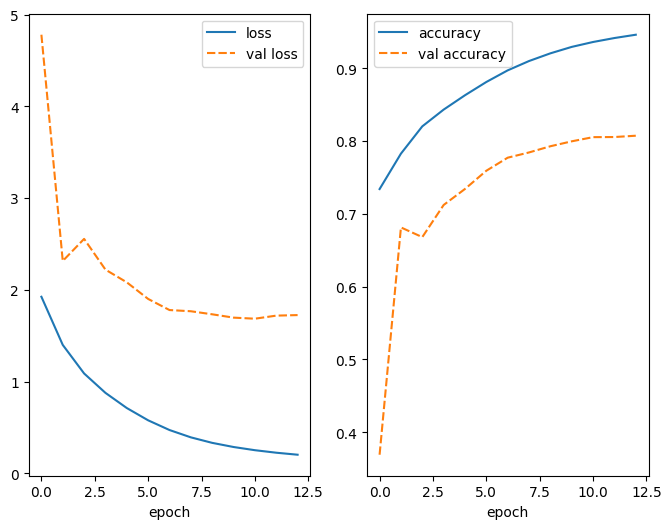

In [11]:
print('Best training loss: ' + str(round(min(results.history['loss']), 3)))
print('Best training accuracy: ' + str(round(max(results.history['accuracy']), 3)))
print('Best validation loss: ' + str(round(min(results.history['val_loss']), 3)))
print('Best validation accuracy: ' + str(round(max(results.history['val_accuracy']), 3)))

# Plot the training loss and accuracy
loss_df = pd.DataFrame({'loss': results.history['loss'], 'val loss': results.history['val_loss']})
acc_df = pd.DataFrame({'accuracy': results.history['accuracy'], 'val accuracy': results.history['val_accuracy']})

fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
sns.lineplot(loss_df, ax=ax[0])
ax[0].set(xlabel='epoch')
sns.lineplot(acc_df, ax=ax[1])
ax[1].set(xlabel='epoch')
plt.show()

### Calculate BLEU and METEOR scores

**Bilingual Evaluation Understudy (BLEU)**, is a score for comparing a candidate translation of text to one or more reference translations.

- BLEU score is more precision based than recalled. In other words, it is based on evaluating whether all words in the generated candidate are in the reference that a manual evaluator comes up with. But it does not check if all words in reference are covered!

- BLEU score does not take into account semantic similarity. The BLEU score looks for exact word matches. But it does not consider the fact that a word such as red is close to the word scarlet for instance. For example, “the cat is on the mat” should be semantically similar to “the cat is over the mat”. However, “the cat is under the mat” does not mean hte same thing! BLEU score fails here.

- Good matches often have clusters of words in candidate that match closely with clusters of words in the reference. BLEU score is not great with capturing this.

**METEOR** evaluates a translation by computing a score based on explicit word-to-word matches between the translation and a given reference translation. If more than one reference translation is available, the translation is scored against each reference independently, and the best scoring pair is used.

Once the model is trained we can evaluate it by calculating the BLEU and METEOR scores. First we should load the weights of the best model found during training. Then create a list of reference (ground truth) and candidate (predicted) sequences:

1. Loop over each batch in the test data (we will use the validation set)

2. Use the model to generate predictions

3. Convert the predicted token ids back into words, and similarly for the actual translation

4. Calculate BLEU and METEOR for all the candidate and reference pairs

In [12]:
# Load the best model found during training
model.load_weights('seq2seq_translator.h5')
print(model.summary())

Model: "seq2seq_attn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 20)]         0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 20)]         0                                            
__________________________________________________________________________________________________
Translator (Translator)         (None, 20, 16789)    7664770     encoder_inputs[0][0]             
                                                                 decoder_inputs[0][0]             
Total params: 7,664,770
Trainable params: 7,664,770
Non-trainable params: 0
__________________________________________________________________________________________________
None


In [13]:
candidates = []
references = []
special_tokens = ['<s>', '</s>', '<pad>']
for i in range(100): # Just make predictions on the first 100 batches
    
    # Predict on the validation set
    predictions = model.predict(val_generator[i][0])

    # Convert the predictions to ids
    predicted_ids = tf.argmax(predictions, axis=-1).numpy()

    # Get the predicted sentence and the reference sentence
    for j in range(predicted_ids.shape[0]):

        # Convert the ids to words
        predicted_sentence = [fr_vocab[i] for i in predicted_ids[j] if fr_vocab[i] not in special_tokens]
        candidates.append(predicted_sentence)

        reference_sentence = [eng_vocab[i] for i in val_generator[i][0][0][j] if eng_vocab[i] not in special_tokens]
        references.append(reference_sentence)

# Smoothing function accounts for cases where the candidate sentence is shorter than the reference sentence
chencherry = SmoothingFunction().method7

# Cumulative - calculation of individual n-gram scores at all orders from 1 to n
c_1g = corpus_bleu(references, candidates, weights=(1, 0, 0, 0), smoothing_function=chencherry)
c_2g = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry)
c_3g = corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry)
c_4g = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry)
print('Cumulative 1-gram: {:.4f}, 2-gram: {:.4f}, 3-gram: {:.4f}, 4-gram: {:.4f}'.format(c_1g, c_2g, c_3g, c_4g))

meteor_scores = [round(meteor([references[i]], candidates[i]), 5) for i in range(len(references))]
print('Completions METEOR: Mean={:.4f}, Max={:.4f}, Min={:.4f}'.format(np.mean(meteor_scores), np.max(meteor_scores), np.min(meteor_scores)))

Cumulative 1-gram: 0.4579, 2-gram: 0.2645, 3-gram: 0.1556, 4-gram: 0.0882
Completions METEOR: Mean=0.1265, Max=0.9815, Min=0.0000


## 1.4 Translate text

Once the model is trained we can now use it to translate some text! First we should load the weights of the best model found during training. Then we can set choose a phrase for translation and (optionally) set the correct translation. Our `translate()` function can take care of the rest!

Input sentence: I am a student.
Translation: Je suis un étudiant.
Predicted translation: je suis etudiant .


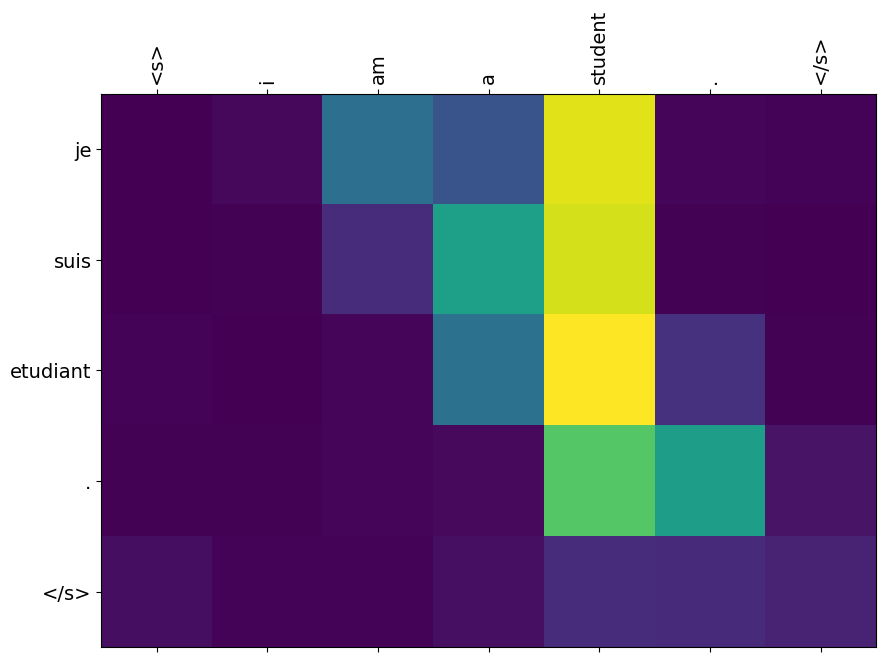

In [16]:
# Load the best model found during training
model.load_weights('seq2seq_translator.h5')

# Test the model on a sentence
input_sentence = "I am a student."
correct_translation = "Je suis un étudiant."

# Translate the sentence
predicted_translation, attn_fig = translator.translate(input_sentence)

print('Input sentence: ' + input_sentence)
print('Translation: ' + correct_translation)
print('Predicted translation: ' + predicted_translation)

# 2 Translation with Transformers (T5)

## 2.0 Import libraries

1. [Transformers](https://huggingface.co/docs/transformers/index) - is a Python library created by Hugging Face 🤗. It provides APIs and tools to easily download and train state-of-the-art pretrained models.

In [17]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate import meteor, meteor_score
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, TFAutoModelForSeq2SeqLM, AdamWeightDecay, pipeline
from datasets import load_dataset, Dataset
%matplotlib inline

# Set the directory to the data folder
data_dir = os.path.join('..', 'data', 'translate')

c:\Python\Virtual Environments\ML-L&V\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load and pre-process data

The data directory should contain the English and French text file. We will simply loop over the file and separate the English and French phrases. However, this time we wont preform any further pre-processing yet.

<div class = "alert alert-block alert-info"><b>Note:</b> This dataset contains ~200K sentence pairs, which would take a very long time to train and evaluate. So, we will limit our data to the first 100k sentences.</div>

In [18]:
# Preprocess the English and French sentences
eng_corpus = []
fr_corpus = []
with open(os.path.join(data_dir, 'eng-fr.txt'), 'r', encoding='utf-8') as file:
    text = file.read().splitlines()

    for line in text[:100000]:
        # Split the line into English and French
        line = line.split('\t')

        # Add to corpus
        eng_corpus.append(line[0])
        fr_corpus.append(line[1])

print('Number of English sentences: ' + str(len(eng_corpus)))
print('Number of French sentences: ' + str(len(fr_corpus)))
print('First 5 sentences: ')
for i in range(5):
    print(eng_corpus[i] + ' -> ' + fr_corpus[i])

Number of English sentences: 100000
Number of French sentences: 100000
First 5 sentences: 
Go. -> Va !
Go. -> Marche.
Go. -> En route !
Go. -> Bouge !
Hi. -> Salut !


## 2.2 Tokenise and Batch the data

Next we will create a [Dataset](https://huggingface.co/docs/datasets/v2.8.0/en/package_reference/main_classes#main-classes) using the Hugging Face 🤗 Dataset class. This allows us to create a dataset from the English and French corpora, split the data into training and test sets (like the SKlearn function) and also batch the data.

We will also create a [Tokeniser](https://huggingface.co/docs/transformers/v4.26.0/en/main_classes/tokenizer) for the T5 model. The tokeniser...tokenises the input and output sequences. It also pads/truncates the sequences to the `max_seq_len` and creates a vocabulary.

Together the `Dataset` and `Tokeniser` automate many of the steps of the data generator and vocabulary creation that we implemented for the Seq2Seq model.

<div class = "alert alert-block alert-info"><b>Note:</b> Models such as T5 and GPT-3 use prompts to inform the model which task it is to perform. In this case we add the prefix "translate English to French: " to the input sequences.</div>

In [19]:
# Set the maximum sequence length and batch size
max_seq_len = 20
batch_size = 64

# Create a dataset from the English and French sentences
dataset = Dataset.from_dict({'eng': eng_corpus, 'fr': fr_corpus})
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)

# The prefix is added to the English sentences to indicate that they are to be translated to French
prefix = "translate English to French: "
def preprocess_function(examples):
    inputs = [prefix + example for example in examples['eng']]
    targets = [example for example in examples['fr']]
    model_inputs = tokeniser(inputs, text_target=targets, max_length=max_seq_len, truncation=True)
    return model_inputs

# Create a tokeniser for the English and French sentences using the T5 model
tokeniser = AutoTokenizer.from_pretrained("t5-small", model_max_length=max_seq_len)
# Apply the preprocessing function to the dataset
tokenised_data = dataset.map(preprocess_function, batched=True, batch_size=batch_size)

# Print the keys and shapes of the training and test datasets
print('Train Dataset: ' + str(tokenised_data['train']))
print('Test Dataset: ' + str(tokenised_data['test']))

# Print the first examples
for i in range(3):
    print('Input Sentence: ' + tokenised_data['train'][i]['eng'])
    print('Input Vector: ' + str(tokenised_data['train'][i]['input_ids']))
    print('Attention Mask: ' + str(tokenised_data['train'][i]['attention_mask']))
    print('Target Sentence: ' + tokenised_data['train'][i]['fr'])
    print('Target Vector: ' + str(tokenised_data['train'][i]['labels']))
    print()

100%|██████████| 313/313 [00:01<00:00, 302.79ba/s]

Train Dataset: Dataset({
    features: ['eng', 'fr', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 80000
})
Test Dataset: Dataset({
    features: ['eng', 'fr', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 20000
})
Input Sentence: Try to calm down.
Input Vector: [13959, 1566, 12, 2379, 10, 5263, 12, 4447, 323, 5, 1]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Target Sentence: Essayez de vous calmer !
Target Vector: [14628, 457, 20, 327, 4447, 49, 3, 55, 1]

Input Sentence: You can trust all of us.
Input Vector: [13959, 1566, 12, 2379, 10, 148, 54, 2019, 66, 13, 178, 5, 1]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Target Sentence: Vous pouvez tous nous faire confiance.
Target Vector: [3, 1930, 3215, 457, 1739, 678, 1143, 15087, 5, 1]

Input Sentence: My conscience is clear.
Input Vector: [13959, 1566, 12, 2379, 10, 499, 15724, 19, 964, 5, 1]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Target Sentence: J'ai la conscience tranquille.
Target Ve

Next we create a [DataCollator]() which is a utility for creating the appropriate encoder and decoder inputs for Seq2Seq models, just as we did with the `MTDataGenerator` class. Then we can create a Tensorflow dataset from the training and test split we created previously/

In [20]:
# Create a data collator for the tokenised data
data_collator = DataCollatorForSeq2Seq(tokenizer=tokeniser, return_tensors="tf")

# Create TensorFlow datasets from the tokenised data
train_set = tokenised_data['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['labels'],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

test_set = tokenised_data['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['labels'],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


## 2.3 Build the T5 Model

With the Hugging Face 🤗 library it is very straightforward to load a pre-trained model, and [there are lots to choose from](https://huggingface.co/models). We just need to provide a compatible model name, in this case 't5-small', which will be downloaded and can then be compiled like a standard Keras model.

In [21]:
# Create the AdamWeightDecay optimizer
optimiser = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)
# Lod the T5 model
model = TFAutoModelForSeq2SeqLM.from_pretrained("t5-small")
model.compile(optimizer=optimiser)
model.summary()

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Model: "tf_t5for_conditional_generation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared (Embedding)           multiple                  16449536  
_________________________________________________________________
encoder (TFT5MainLayer)      multiple                  35330816  
_________________________________________________________________
decoder (TFT5MainLayer)      multiple                  41625344  
Total params: 60,506,624
Trainable params: 60,506,624
Non-trainable params: 0
_________________________________________________________________


### Train and evaluate the model

Here we train the model using `model.fit()` as before. However, instead of saving the model weights during training, using the `ModelCheckpoint`, we will simply save the fine-tuned model once training is complete. Usually  only a few epochs are necessary when fine-tuning a model.

<div class = "alert alert-block alert-warning"><b>Warning:</b> **Please do not run this cell on UWE machines/CSCT cloud!**<br>
This training process can take a *very* long time! It could take many hours, depending on your hardware, and especially if you do not have a GPU.  <br>Instead please either run this notebook on Google Colab, or skip this cell and load one of the pre-trained models provided (below).
</div>

In [22]:
model_earlystp = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.01,
    patience=1,
    verbose=0,
    mode='min',
    restore_best_weights=True)

# Fit the model
results = model.fit(train_set, epochs=5, validation_data=test_set, callbacks=[model_earlystp])

# Save the model
model.save_pretrained('t5_translator')
tokeniser.save_pretrained('t5_translator')

Epoch 1/5
1250/1250 [==============================] - 672s 527ms/step - loss: 1.0075 - val_loss: 0.7267
Epoch 2/5
1250/1250 [==============================] - 423s 338ms/step - loss: 0.8698 - val_loss: 0.6813
Epoch 3/5
1250/1250 [==============================] - 493s 395ms/step - loss: 0.8154 - val_loss: 0.6554
Epoch 4/5
1250/1250 [==============================] - 509s 407ms/step - loss: 0.7837 - val_loss: 0.6342
Epoch 5/5
1250/1250 [==============================] - 407s 325ms/step - loss: 0.7548 - val_loss: 0.6192


('t5_translator\\tokenizer_config.json',
 't5_translator\\special_tokens_map.json',
 't5_translator\\tokenizer.json')

Best training loss: 0.75
Best validation loss: 0.619


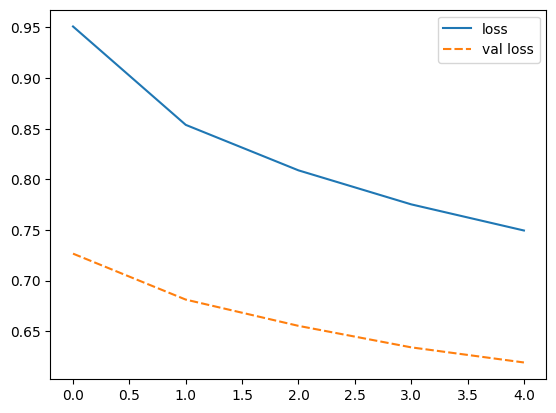

In [26]:
print('Best training loss: ' + str(round(min(results.history['loss']), 3)))
print('Best validation loss: ' + str(round(min(results.history['val_loss']), 3)))

# # Plot the training loss and validation loss
loss_df = pd.DataFrame({'loss': results.history['loss'], 'val loss': results.history['val_loss']})
plt = sns.lineplot(data=loss_df)

### Calculate BLEU and METEOR scores

Once the model is trained we can evaluate it by calculating the BLEU and METEOR scores. First we should load the weights of the model as well as the tokeniser. The process is similar to before:

1. Loop over each batch in the test set

2. Use the model to generate predictions

3. Convert the predicted token ids back into words, and similarly for the actual translation. In this case the `.decode()` function returns a complete string, so we need to split them back into tokens and ignore everything after the `</s>` token.

4. Calculate BLEU and METEOR for all the candidate and reference pairs

In [27]:
# Load the best model found during training
model = TFAutoModelForSeq2SeqLM.from_pretrained('t5_translator')
tokeniser = AutoTokenizer.from_pretrained('t5_translator')

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5_translator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [28]:
candidates = []
references = []
for i, example in enumerate(test_set):

    # Predict on the test set
    inp_ids, attn_mask, labels = example[0]['input_ids'], example[0]['attention_mask'], example[1]
    outputs = model(input_ids=inp_ids, attention_mask=attn_mask, decoder_input_ids=None, labels=labels)

    # Convert the logits to predicted ids
    predictions = tf.nn.softmax(outputs['logits'], axis=-1)
    predicted_ids = tf.argmax(predictions, axis=-1).numpy()

    # Get the predicted sentences and the reference sentence
    for j in range(predicted_ids.shape[0]):

        # Use the tokeniser to decode the predicted ids
        predicted_sentence = tokeniser.decode(predicted_ids[j], skip_special_tokens=False)
        predicted_sentence = re.sub(r"([?.!,¿])", r" \1 ", predicted_sentence)
        # Ignore everything after the </s> token
        predicted_sentence = predicted_sentence.split('</s>')[0]
        predicted_sentence = predicted_sentence.strip().split(' ')
        candidates.append(predicted_sentence)

        # Use the tokeniser to decode the reference ids from the labels
        label_ids = np.delete(labels[j], np.where(labels[j] == -100)) # Remove the padding tokens
        reference_sentence = tokeniser.decode(label_ids, skip_special_tokens=True)
        reference_sentence = re.sub(r"([?.!,¿])", r" \1 ", reference_sentence)
        reference_sentence = reference_sentence.strip().split(' ')
        references.append(reference_sentence)

# Smoothing function accounts for cases where the candidate sentence is shorter than the reference sentence
chencherry = SmoothingFunction().method7

# Cumulative - calculation of individual n-gram scores at all orders from 1 to n
c_1g = corpus_bleu(references, candidates, weights=(1, 0, 0, 0), smoothing_function=chencherry)
c_2g = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry)
c_3g = corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry)
c_4g = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry)
print('Cumulative 1-gram: {:.4f}, 2-gram: {:.4f}, 3-gram: {:.4f}, 4-gram: {:.4f}'.format(c_1g, c_2g, c_3g, c_4g))

meteor_scores = [round(meteor([references[i]], candidates[i]), 5) for i in range(len(references))]
print('Completions METEOR: Mean={:.4f}, Max={:.4f}, Min={:.4f}'.format(np.mean(meteor_scores), np.max(meteor_scores), np.min(meteor_scores)))

Cumulative 1-gram: 0.4620, 2-gram: 0.2668, 3-gram: 0.1569, 4-gram: 0.0889
Completions METEOR: Mean=0.6917, Max=0.9996, Min=0.0000


## 2.4 Translate text

Once the model is trained we can now use it to translate some text! First we should load the weights of the model as well as the tokeniser. Then we can set choose a phrase for translation and (optionally) set the correct translation. Then we can use a [Pipeline](https://huggingface.co/docs/transformers/v4.26.0/en/main_classes/pipelines#transformers.pipeline) to create a full end-to-end translation function with our model and tokeniser.

In [29]:
# Load the best model found during training
model = TFAutoModelForSeq2SeqLM.from_pretrained('t5_translator')
tokeniser = AutoTokenizer.from_pretrained('t5_translator')

# Test the model on a sentence
input_sentence = "I am a student."
correct_translation = "Je suis un étudiant."

# Create a pipeline to translate the input sentence
translator = pipeline("translation_en_to_fr", model=model, tokenizer=tokeniser)
predicted_translation = translator(input_sentence)

print('Input sentence: ' + input_sentence)
print('Translation: ' + correct_translation)
print('Predicted translation: ' + predicted_translation[0]['translation_text'])

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5_translator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
c:\Python\Virtual Environments\ML-L&V\lib\site-packages\transformers\generation\tf_utils.py:603: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


Input sentence: I am a student.
Translation: Je suis un étudiant.
Predicted translation: Je suis étudiant.
